# Wasserstein GAN gradient penalt (WGAN-GP)

In WGAN  the discriminator is called the critic since it’s not trained to classify


WGAN-GP is an alternative Wasserstein GAN (WGAN) involves weights  clipping.  WGAN-GP instead of clipping the weights, penalize the norm of gradient of the critic with respect to its input

$$ L_{WGAN-GP}=E[D(G(z))]-E[D(x)]+\lambda E[(||\Delta_{z}D(G(z))||_{2}-1)^{2}] $$

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras as K
from tensorflow.keras.preprocessing.image import load_img

In [3]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,fname='flower_photos',untar=True)
data_dir = pathlib.Path(data_dir)

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


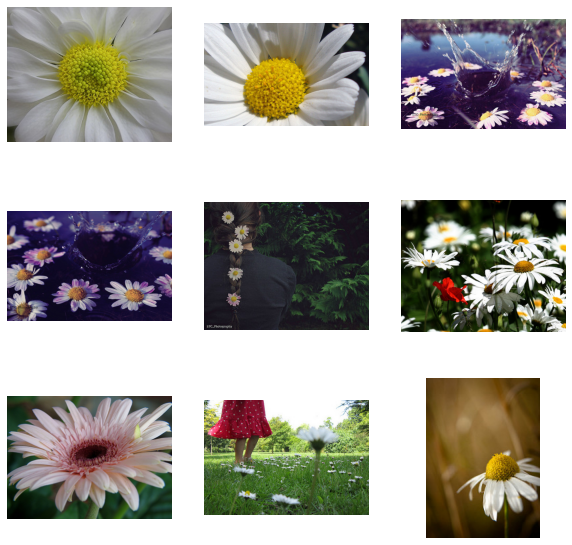

In [8]:

plt.figure(figsize=(10, 10))
for i,img in enumerate(list(data_dir.glob('*/*.jpg'))[:9]):
    plt.subplot(3, 3, i + 1)
    plt.imshow(load_img(img))
    plt.axis("off")

In [9]:
batch_size = 32
img_height = 116
img_width = 116

In [10]:
x_train=[]
for i,img in enumerate(data_dir.glob('*/*.jpg')):
    image=load_img(img,target_size=(img_height,img_width))
    image/=np.max(image)
    #image=tf.cast(image,dtype=tf.float32)
    image=image.astype(np.float32)
    image=(image-.5)/.5
    x_train.append(image)

In [11]:
np.min(x_train[2]),np.max(x_train[2])

(-1.0, 1.0)

In [12]:
len(x_train)

3670

In [13]:
latent_dim=100
buffer_size=len(x_train)
x_train_d=tf.data.Dataset.from_tensor_slices(x_train).shuffle(buffer_size).batch(batch_size)

In [10]:
# for x in x_train_d:
#     print(x.shape)
#     print(x.dtype)
#     break


(32, 116, 116, 3)
<dtype: 'float32'>


In [21]:
K.backend.clear_session()
init_w=K.initializers.RandomNormal(mean=0,stddev=0.2)

# Wasserstein Critic Network

This network is very similar to Discriminator, but it is without the sigmoid function and outputs a scalar score rather than a probability

In [22]:
critic=K.models.Sequential([
                     K.layers.InputLayer(input_shape=(img_height,img_width,3)),
    
                     K.layers.Conv2D(64,kernel_size=4,strides=2,padding='same'),
                     K.layers.LeakyReLU(alpha=0.2),
    
                     K.layers.Conv2D(100,kernel_size=4,strides=2,padding='same'),
                     K.layers.BatchNormalization(),
                     K.layers.LeakyReLU(alpha=0.2),
                    
                     K.layers.Conv2D(100,kernel_size=4,strides=2,padding='same'),
                     K.layers.LeakyReLU(alpha=0.2),
    
                     K.layers.Flatten(),
                     K.layers.Dropout(0.2),
                     K.layers.Dense(1)
                                   ],name='critic')
critic.summary()

Model: "critic"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 58, 58, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 58, 58, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 100)       102500    
                                                                 
 batch_normalization (BatchN  (None, 29, 29, 100)      400       
 ormalization)                                                   
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 29, 29, 100)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 15, 100)       160100    
                                                            

In [23]:
generator =K.Sequential( [
        K.Input(shape=(latent_dim,)),
        K.layers.Dense(10*10*100,use_bias=False),
        K.layers.ReLU(),
        K.layers.Reshape((10, 10, 100)),
        K.layers.UpSampling2D(size=3),
    
        K.layers.Conv2D(64, kernel_size=3, padding="same",kernel_initializer=init_w,use_bias=False ),
        K.layers.BatchNormalization(),
        K.layers.ReLU(),
        K.layers.UpSampling2D(size=2),
    
        K.layers.Conv2D(128, kernel_size=3,  padding="same",use_bias=False ),
        K.layers.BatchNormalization(),
        K.layers.ReLU(),   
        K.layers.UpSampling2D(),
        
        K.layers.Conv2D(128, kernel_size=3,  padding="same",use_bias=False ),
        K.layers.BatchNormalization(),
        K.layers.ReLU(),   
    
        K.layers.Conv2D(3, kernel_size=5, activation="tanh",use_bias=False)
                          ],'generator')
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 10000)             1000000   
                                                                 
 re_lu (ReLU)                (None, 10000)             0         
                                                                 
 reshape (Reshape)           (None, 10, 10, 100)       0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 30, 30, 100)      0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 30, 30, 64)        57600     
                                                                 
 batch_normalization_1 (Batc  (None, 30, 30, 64)       256       
 hNormalization)                                         

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


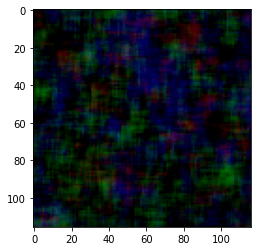

In [24]:
z_random_latent_vectors=tf.random.normal(shape=(1,latent_dim))
generated_img=generator(z_random_latent_vectors)
generated_img=tf.reshape(generated_img,(img_height,img_width,3))
plt.imshow(generated_img.numpy())

![](./images/wgan_gp.jpg)

[source of image](https://arxiv.org/pdf/1704.00028.pdf)

In [15]:
class WGAN_GP(K.Model):
    def __init__(self,critic,generator,latent_dim,n_critic=3,gp_weight=10.0):
        super(WGAN_GP,self).__init__()
        self.critic=critic
        self.generator=generator
        self.latent_dim=latent_dim
        # the number of critic iterations per generator iteration
        self.n_critic=n_critic
        # The gradient penalty coefficient      
        self.gp_weight=gp_weight
        self.c_loss_metric=K.metrics.Mean(name='c_loss')
        self.g_loss_metric=K.metrics.Mean(name='g_loss')
    def compile(self,c_optimizer,g_optimizer):
        super(WGAN_GP,self).compile()
        self.c_optimizer=c_optimizer
        self.g_optimizer=g_optimizer
    
    @property
    def metrics(self):
        return [self.c_loss_metric,self.g_loss_metric]
    @tf.function
    def wasserstein_loss(self,real_output,fake_output):
        fake_l=tf.reduce_mean(fake_output)
        real_l=tf.reduce_mean(real_output)
        return fake_l-real_l
    @tf.function
    def generator_loss(self,fake_output):
        return -tf.reduce_mean(fake_output)
    
    def gradient_penalty(self,batch_size,real_imgs,fake_imgs):
        alpha = tf.random.normal([batch_size, 1, 1, 1])
        interpolated_imgs=(alpha*real_imgs)+(1-alpha)*fake_imgs
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated_imgs)
            pred_interpolated=self.critic(interpolated_imgs)
        grads=gp_tape.gradient(pred_interpolated,[interpolated_imgs])[0]
        norm=tf.sqrt(tf.reduce_sum(tf.square(grads),axis=[1,2,3]))
        gp=tf.reduce_mean((norm-1)**2)
        return gp
    
    def train_step(self,real_imgs):
        batch_size=tf.shape(real_imgs)[0]
        for _ in range(self.n_critic):
            # Get the latent vector
            z_random_latent_vectors=tf.random.normal([batch_size,self.latent_dim])
            with tf.GradientTape() as tape:
                generated_imgs=self.generator(z_random_latent_vectors)
                fake_output_=self.critic(generated_imgs)
                real_output_=self.critic(real_imgs)
                # Calculate the critic loss using the predicted fake and real output
                c_loss_     =self.wasserstein_loss(real_output_,fake_output_)
                # Calculate the gradient penalty
                g_penalty=self.gradient_penalty(batch_size,real_imgs,generated_imgs)
                # Add the gradient penalty to the original discriminator loss
                c_loss=c_loss_+self.gp_weight*g_penalty
            grads=tape.gradient(c_loss,self.critic.trainable_weights)
            self.c_optimizer.apply_gradients(zip(grads,self.critic.trainable_weights))
        # GENERATOR
        z_random_latent_vectors=tf.random.normal([batch_size,self.latent_dim])
        with tf.GradientTape() as tape:
            generated_imgs=self.generator(z_random_latent_vectors)
            fake_output=self.critic(generated_imgs)
            g_loss=self.generator_loss(fake_output)
            
        # Get the gradients w.r.t the generator loss
        gen_grads=tape.gradient(g_loss,self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(gen_grads,self.generator.trainable_weights))
        
        self.c_loss_metric.update_state(c_loss)
        self.g_loss_metric.update_state(g_loss)
        return {'c_loss':self.c_loss_metric.result(),"g_loss":self.g_loss_metric.result()}

In [16]:
K.backend.clear_session()

In [17]:
wgan_gp=WGAN_GP(critic=critic,generator=generator,latent_dim=latent_dim)
wgan_gp.compile(c_optimizer=K.optimizers.Adam( learning_rate=0.0002, beta_1=0.5, beta_2=0.9 ),
                g_optimizer=K.optimizers.Adam(  learning_rate=0.0002, beta_1=0.5, beta_2=0.9 ))

In [ ]:
wgan_gp.fit(x_train_d,epochs=100,batch_size=batch_size)

In [ ]:
noise=tf.random.normal((1,latent_dim))
gen=wgan_gp.generator.predict(noise)
gen=tf.reshape(gen,(116,116,3))
plt.imshow(gen)

In [ ]:
noise=tf.random.normal((10,latent_dim))
imgs=wgan_gp.generator.predict(noise)


In [ ]:
n=10
plt.figure(figsize=(24,10))
for i in range(n):
  bx=plt.subplot(2,10,i+n+1)
  im=tf.reshape(imgs[1],(116,116,3))
  plt.imshow(im)
  plt.axis('off')

**Reference**
- [WGAN-GP](https://arxiv.org/pdf/1704.00028.pdf)

- [Keras](https://keras.io/examples/generative/wgan_gp/)